In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import pandas as pd
processed_data_dir = 'processed_data'


In [21]:
import os
import time
# Load em_stack
import tifffile

em_file_name = 'dp1_em_downsampled_stack'
em_stack_file = os.path.join(processed_data_dir, f'lm_em_stacks/{em_file_name}.tif')

# em_file_name = 'dp1_em_downsampled_stack_subsampled_by_2_mean'
# em_stack_subsampled_file = os.path.join(processed_data_dir, f'transformed_stacks/{em_file_name}.tif')

em_stack_ss = tifffile.imread(em_stack_file)
em_stack_ss.shape


(2054, 1594, 1568)

In [22]:
from compute_affine3d_from_landmarks import compute_affine_transform_3d, transform_image_stack, invert_affine_matrix
import numpy as np

landmarks_file = os.path.join(processed_data_dir, 'landmarks/landmarks_Nila_confirmed.csv')
landmarkdf = pd.read_csv(landmarks_file, header=0)


em_points = landmarkdf[['z_em_subsampled', 'y_em_subsampled', 'x_em_subsampled']].values
if em_file_name.endswith('subsampled_by_2_mean') or em_file_name.endswith('subsampled_by_2'):
    em_points = em_points / 2 # correspond to the subsampled by 2 stack

lm_upsample_factor_xy = 4
# Scaled z_lm by 100
lm_upsample_factor_z = 100
landmarkdf['z_lm'] = landmarkdf['z_lm'] * lm_upsample_factor_z
landmarkdf['y_lm'] = landmarkdf['y_lm'] * lm_upsample_factor_xy
landmarkdf['x_lm'] = landmarkdf['x_lm'] * lm_upsample_factor_xy
lm_points = landmarkdf[['z_lm', 'y_lm', 'x_lm']].values

# Compute the affine transformation
affine3d_mat = compute_affine_transform_3d(em_points, lm_points)
inv_affine3d_mat = invert_affine_matrix(affine3d_mat)

print("Best-fit 3D Affine Transformation Matrix (4x4):\n", affine3d_mat)


Best-fit 3D Affine Transformation Matrix (4x4):
 [[-1.56118300e+00  8.56863221e-01 -5.88513257e-01  2.38345125e+03]
 [ 6.62843066e-01  9.28771127e-01 -6.55103407e-01 -2.18304752e+02]
 [ 2.88855178e-02  8.64149328e-01  1.55424897e+00 -1.15605645e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [23]:
lm_stack_file = os.path.join(processed_data_dir, 'lm_em_stacks/dp1_lm_anatomy_trial11_CLAHE.tif')
lm_stack = tifffile.imread(lm_stack_file)
lm_stack.shape

(8, 256, 477)

In [24]:
import numpy as np

def transformed_bounds(image_shape, affine_matrix):
    Z, Y, X = image_shape

    # Original corners of the volume
    corners = np.array([
        [0, 0, 0, 1],
        [X - 1, 0, 0, 1],
        [0, Y - 1, 0, 1],
        [0, 0, Z - 1, 1],
        [X - 1, Y - 1, 0, 1],
        [X - 1, 0, Z - 1, 1],
        [0, Y - 1, Z - 1, 1],
        [X - 1, Y - 1, Z - 1, 1],
    ]).T  # Shape: (4, 8)

    # Apply affine transform to all corners
    transformed_corners = affine_matrix @ corners
    transformed_corners = transformed_corners[:3] / transformed_corners[3]

    # Find min and max bounds in transformed coordinates
    mins = np.min(transformed_corners, axis=1)
    maxs = np.max(transformed_corners, axis=1)

    return mins, maxs

mins, maxs = transformed_bounds(em_stack_ss.shape, affine3d_mat)
print("Transformed bounds (min, max):", mins, maxs)

Transformed bounds (min, max): [-1271.1402354  -1563.23204772 -1156.0564488 ] [3748.43436015 2299.90273739 3456.67016985]


In [25]:
output_shape = (800, 256*lm_upsample_factor_xy, 477*lm_upsample_factor_xy) # Same shape as the LM stack, with z dimension scaled by 100
em_stack_ss_transformed = transform_image_stack(em_stack_ss, inv_affine3d_mat,
                                                order=1, output_shape=output_shape)
# Save em_stack_transformed
transformed_file_name = f'{em_file_name}_transformed'
em_stack_ss_transformed_file = os.path.join(processed_data_dir, f'transformed_stacks/{transformed_file_name}.tif')
tifffile.imwrite(em_stack_ss_transformed_file, em_stack_ss_transformed)
# Also save the transformation matrix
affine3d_mat_file = os.path.join(processed_data_dir, f'transformed_stacks/{transformed_file_name}_affine3d_mat.txt')
np.savetxt(affine3d_mat_file, affine3d_mat)

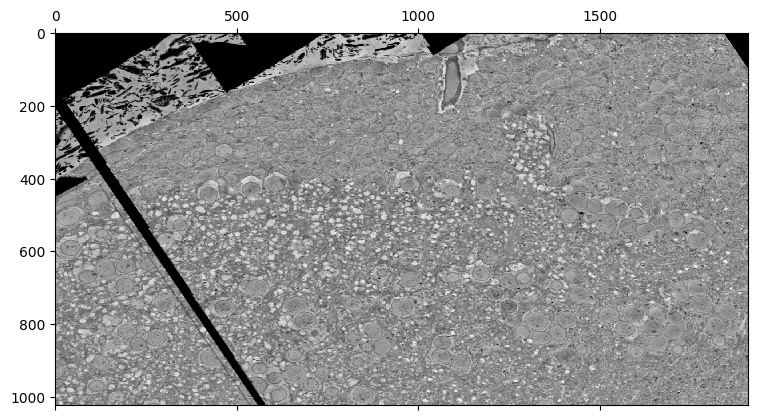

In [26]:
import matplotlib.pyplot as plt
plt.matshow(em_stack_ss_transformed[400], cmap='gray')